# Modelo de ABM com Microestrutura de Mercado

Este notebook apresenta um modelo de simulação baseado em agentes (ABM) que incorpora uma microestrutura de mercado por meio de um _order book_. O modelo inclui:

- **Classes de Microestrutura de Mercado:**  
  - `Ordem`: Representa uma ordem de compra ou venda.
  - `Transacao`: Representa a execução de uma transação entre um comprador e um vendedor.
  - `OrderBook`: Armazena e processa as ordens, casando-as quando possível.

- **Classes do ABM:**  
  - `BancoCentral`: Define os parâmetros macroeconômicos.
  - `Midia`: Gera notícias diárias que influenciam os agentes.
  - `Imovel`: Representa um imóvel que gera fluxo de aluguel.
  - `Agente`: Representa um investidor que toma decisões com base em seu sentimento, alocação desejada e estratégias de rebalanceamento.
  - `FII`: Representa um fundo imobiliário, cujo preço evolui com base nas transações.
  - `Mercado`: Gerencia o conjunto de agentes, o FII, o order book e o processamento diário das ordens.

Em seguida, cada parte do código será apresentada com comentários explicativos.


In [ ]:
from dataclasses import dataclass, field
from typing import List, Dict, Optional
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

utils.py

DRY

In [ ]:
pass

- Classe Ordem

A classe Ordem representa uma ordem de compra ou venda no mercado. Ela
contém o tipo de ordem ("compra" ou "venda"), o agente que originou a ordem,
o ativo a ser negociado, o preço limite e a quantidade.

In [ ]:
@dataclass
class Ordem:
    tipo: str            # "compra" ou "venda"
    agente: "Agente"     # Agente que criou a ordem
    ativo: str           # Nome do ativo (ex.: "FII")
    preco_limite: float  # Preço máximo (para compra) ou mínimo (para venda)
    quantidade: int      # Quantidade a negociar

- Classe Transacao

 A classe Transacao representa a execução de uma transação entre um comprador
 e um vendedor. Quando uma transação é executada, os saldos dos agentes são
 ajustados, e as carteiras são atualizadas conforme a quantidade negociada e o
 preço de execução.

In [ ]:
@dataclass
class Transacao:
    comprador: "Agente"
    vendedor: "Agente"
    ativo: str
    quantidade: int
    preco_execucao: float

    def executar(self) -> None:
      valor_total = self.quantidade * self.preco_execucao
      # Atualiza tanto saldo quanto caixa
      self.comprador.saldo -= valor_total
      self.comprador.caixa -= valor_total
      self.vendedor.saldo += valor_total
      self.vendedor.caixa += valor_total
      self.comprador.carteira[self.ativo] = (
          self.comprador.carteira.get(self.ativo, 0) + self.quantidade
      )
      if self.ativo in self.vendedor.carteira:
          self.vendedor.carteira[self.ativo] -= self.quantidade
          if self.vendedor.carteira[self.ativo] <= 0:
              del self.vendedor.carteira[self.ativo]


- Classe OrderBook

 A classe OrderBook representa o livro de ordens do mercado. Ela armazena
 as ordens de compra e venda (organizadas por ativo) e possui um método para
 processar e casar as ordens (executando transações quando o preço limite da
 compra for maior ou igual ao da venda).

In [ ]:
class OrderBook:
    def __init__(self, params: dict = None) -> None:
        self.ordens_compra = {}
        self.ordens_venda = {}
        self.params = params if params is not None else {}

    def adicionar_ordem(self, ordem: Ordem) -> None:
        if ordem.tipo == "compra":
            self.ordens_compra.setdefault(ordem.ativo, []).append(ordem)
        elif ordem.tipo == "venda":
            self.ordens_venda.setdefault(ordem.ativo, []).append(ordem)

    def executar_ordens(self, ativo: str, mercado: "Mercado") -> None:
        if ativo in self.ordens_compra and ativo in self.ordens_venda:
            # Ordena as ordens: compras por preço limite decrescente e vendas por crescente.
            self.ordens_compra[ativo].sort(key=lambda x: x.preco_limite, reverse=True)
            self.ordens_venda[ativo].sort(key=lambda x: x.preco_limite)
            while self.ordens_compra[ativo] and self.ordens_venda[ativo]:
                ordem_compra = self.ordens_compra[ativo][0]
                ordem_venda = self.ordens_venda[ativo][0]
                if ordem_compra.preco_limite >= ordem_venda.preco_limite:
                    # Possibilidade de parametrizar o método de cálculo do preço de execução.
                    preco_execucao = (ordem_compra.preco_limite + ordem_venda.preco_limite) / 2
                    quantidade_exec = min(ordem_compra.quantidade, ordem_venda.quantidade)
                    transacao = Transacao(
                        comprador=ordem_compra.agente,
                        vendedor=ordem_venda.agente,
                        ativo=ativo,
                        quantidade=quantidade_exec,
                        preco_execucao=preco_execucao,
                    )
                    transacao.executar()
                    # Atualiza o preço do ativo no FII.
                    mercado.fii.preco_cota = preco_execucao
                    ordem_compra.quantidade -= quantidade_exec
                    ordem_venda.quantidade -= quantidade_exec
                    if ordem_compra.quantidade == 0:
                        self.ordens_compra[ativo].pop(0)
                    if ordem_venda.quantidade == 0:
                        self.ordens_venda[ativo].pop(0)
                else:
                    break

    def imprimir(self) -> None:
        print("== Order Book ==")
        print("Ordens de COMPRA:")
        for ativo, ordens in self.ordens_compra.items():
            print(f" Ativo: {ativo}")
            for ordem in ordens:
                print(f"  -> Agente {ordem.agente.id}: Preço Limite: R${ordem.preco_limite:.2f}, Quantidade: {ordem.quantidade}")
        print("Ordens de VENDA:")
        for ativo, ordens in self.ordens_venda.items():
            print(f" Ativo: {ativo}")
            for ordem in ordens:
                print(f"  -> Agente {ordem.agente.id}: Preço Limite: R${ordem.preco_limite:.2f}, Quantidade: {ordem.quantidade}")

## Classes do ABM

- **BancoCentral:** Define parâmetros macroeconômicos como taxa SELIC, expectativa de inflação e prêmio de risco.
- **Midia:** Gera um índice de notícias aleatório que influencia o sentimento dos agentes.
- **Imovel:** Representa um imóvel que gera fluxo de aluguel.
- **Agente:** Modela um investidor que possui um saldo, uma carteira de ativos, e toma decisões baseadas em seu sentimento, na alocação desejada e em expectativas. Cada agente pode criar ordens (de compra ou venda) com base em uma estratégia de rebalanceamento.
- **FII:** Representa um fundo imobiliário cujo preço (preço da cota) evolui com as transações. Ele também distribui dividendos e acumula caixa.
- **Mercado:** Gerencia o conjunto de agentes, o FII, o order book e o processamento diário das ordens. Ele atualiza o preço do FII, distribui dividendos e atualiza a volatilidade histórica dos retornos.


In [ ]:
class BancoCentral:
    def __init__(self, params: dict = None) -> None:
        params = params if params is not None else {}
        self.taxa_selic = params.get("taxa_selic", 0.15)
        self.expectativa_inflacao = params.get("expectativa_inflacao", 0.07)
        self.premio_risco = params.get("premio_risco", 0.08)

In [ ]:
class Midia:
    def __init__(self, params: dict = None) -> None:
        self.params = params if params is not None else {}
        self.noticia_min = self.params.get("noticia_min", -0.5)
        self.noticia_max = self.params.get("noticia_max", 0.5)

    def gerar_noticia(self):
        return np.random.uniform(self.noticia_min, self.noticia_max)

In [ ]:
class Imovel:
    def __init__(self, valor: float, vacancia: float, custo_manutencao: float, params: dict=None) -> None:
        self.valor = valor
        self.vacancia = vacancia
        self.custo_manutencao = custo_manutencao
        # Recebe os parâmetros customizáveis ou usa os valores default
        self.params = params if params is not None else {}
        self.aluguel_factor = self.params.get("aluguel_factor", 0.005)
        self.desvio_normal = self.params.get("desvio_normal", 0.1)
        self.aluguel = self.valor * self.aluguel_factor

    def gerar_fluxo_aluguel(self) -> float:
        return self.aluguel * (1 - self.vacancia * (1 + np.random.normal(0, self.desvio_normal)))

In [ ]:
class FII:
    def __init__(self, num_cotas: int, caixa: float, params: list = None) -> None:
        self.num_cotas = num_cotas
        self.caixa = caixa
        self.imoveis = []
        self.retornos_diarios = []
        self.preco_cota = 0
        self.historico_precos = []
        # Guarda os parâmetros passados ou usa um dicionário vazio se não forem fornecidos
        self.params = params if params is not None else {}

    def valor_patrimonial_por_acao(self) -> None:
        return (self.caixa + sum(imovel.valor for imovel in self.imoveis)) / self.num_cotas

    def adicionar_imovel(self, imovel: Imovel) -> None:
        self.imoveis.append(imovel)

    def calcular_fluxo_aluguel(self) -> float:
        return sum(imovel.gerar_fluxo_aluguel() for imovel in self.imoveis)

    def distribuir_dividendos(self) -> float:
        fluxo_aluguel = self.calcular_fluxo_aluguel()
        # Usa os parâmetros configuráveis para distribuição dos dividendos
        dividendos_rate = self.params.get("dividendos_taxa", 0.95)
        caixa_rate = self.params.get("dividendos_caixa_taxa", 0.05)
        dividendos = fluxo_aluguel * dividendos_rate / self.num_cotas if self.num_cotas > 0 else 0
        self.caixa += fluxo_aluguel * caixa_rate
        return dividendos

    def atualizar_caixa_para_despesas(self, despesas: float) -> None:
        self.caixa -= despesas
        if self.caixa < 0:
            self.caixa = 0

    def atualizar_imoveis_investir(self, inflacao: float) -> None:
        # Usa o parâmetro para definir a fração do caixa a investir
        investimento_fracao = self.params.get("investimento_fracao", 0.50)
        valor_investir = investimento_fracao * self.caixa
        self.caixa -= valor_investir

        for imovel in self.imoveis:
            imovel.valor *= (1 + inflacao)
            imovel.valor += (valor_investir / len(self.imoveis))
            imovel.aluguel = imovel.valor * 0.005
            print(f"Imovel atualizado: Valor: R${imovel.valor:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

        print(f"[FII] Imóveis atualizados; reinvestido: R${valor_investir:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))

    def realizar_investimento(self, valor: float) -> None:
        if self.caixa >= valor:
            self.caixa -= valor
        else:
            raise ValueError("Caixa insuficiente para realizar o investimento.")

    def calcular_retorno_diario(self, novo_preco_cota: float) -> None:
        if self.preco_cota > 0:
            retorno = (novo_preco_cota - self.preco_cota) / self.preco_cota
            self.retornos_diarios.append(retorno)
        self.preco_cota = novo_preco_cota

    def obter_estatisticas_retornos(self) -> None or dict:
        if not self.retornos_diarios:
            return None
        media_retorno = np.mean(self.retornos_diarios)
        volatilidade = np.std(self.retornos_diarios)
        return {"media_retorno": media_retorno, "volatilidade": volatilidade}

    def inicializar_historico(self, dias: int=30) -> list:
        self.historico_precos = []
        for _ in range(dias):
            self.historico_precos.append(self.valor_patrimonial_por_acao())
        return self.historico_precos


In [ ]:
class Agente:
    def __init__(self, id: int, literacia_financeira: float, caixa: float, cotas: int, expectativa_inflacao: float, expectativa_premio: float, historico_precos: list, params: dict=None) -> None:
        self.id = id
        self.LF = literacia_financeira
        self.caixa = caixa
        self.cotas = cotas

        # Atributos de negociação
        self.saldo = caixa
        self.carteira = {"FII": cotas}

        # Atributos decisórios
        self.sentimento = 0
        self.RD = 0
        self.percentual_alocacao = 0

        # Expectativas
        self.expectativa_inflacao = expectativa_inflacao
        self.expectativa_premio = expectativa_premio

        # Histórico e estatísticas
        self.historico_precos = historico_precos  # Histórico de preços do ativo
        self.retornos_dia = []                   # Retornos diários registrados
        self.historico_riqueza = [caixa + cotas * historico_precos[-1]]
        self.dividendos_recebidos = 0

        # Lista para registrar o sentimento diário
        self.historico_sentimentos = []

        # Lista de vizinhos (outros agentes)
        self.vizinhos = []

        # Parâmetros específicos do agente (opcional)
        self.params = params if params is not None else {}

    def definir_vizinhos(self, todos_agentes: list, num_vizinhos: int = 3) -> None:
        candidatos = [agente for agente in todos_agentes if agente.id != self.id]
        self.vizinhos = random.sample(candidatos, min(num_vizinhos, len(candidatos)))

    def calcular_preco_esperado(self, literacia_financeira: float, parametros: float, dividendos: float) -> float:
        # Utiliza o parâmetro beta presente em 'parametros'
        x = literacia_financeira / (np.exp(1) ** parametros["beta"])
        z = (1 - parametros["beta"]) * (1 - literacia_financeira)
        y = 1 - x - z

        # Preço fundamentalista: usa dividendos e expectativas do agente
        preco_fundamentalista = dividendos * 12 * (1 + self.expectativa_inflacao) / self.expectativa_premio
        retorno_fundamentalista = np.log(preco_fundamentalista) - np.log(self.historico_precos[-1])

        # Estratégia Chartista: usa janela e alfas configuráveis
        window_chart = self.params.get("window_chart", 21)
        if len(self.historico_precos) >= window_chart:
            ema_short = pd.Series(self.historico_precos).ewm(alpha=self.params.get("alpha_chart_short", 0.3), adjust=False).mean().iloc[-1]
            ema_long = pd.Series(self.historico_precos).ewm(alpha=self.params.get("alpha_chart_long", 0.1), adjust=False).mean().iloc[-1]
            retorno_expeculador = np.log(ema_short / ema_long)
        else:
            retorno_expeculador = 0.0

        # Ruído no retorno: desvio padrão parametrizável
        ruido_std = self.params.get("ruido_std", 0.1)
        retorno_ruido = np.random.normal(0, ruido_std)

        retorno_expectativa = (x * retorno_fundamentalista) + (y * retorno_expeculador) + (z * retorno_ruido)
        preco_esperado = self.historico_precos[-1] * np.exp(retorno_expectativa)
        return preco_esperado

    def atualizar_caixa(self, taxa_selic: float, dividendos: float) -> None:
        taxa_selic_mes = (1 + taxa_selic) ** (1 / 12) - 1
        self.caixa += self.caixa * (taxa_selic_mes + 1)
        self.caixa += dividendos

    def calcular_I_privada(self, n: int = 5) -> float:
        # Permite parametrizar os pesos dos componentes do I_privada
        peso_sentimento = self.params.get("peso_sentimento", 0.8)
        peso_riqueza = self.params.get("peso_riqueza", 0.4)
        componente_sentimento = self.sentimento

        if len(self.historico_riqueza) >= n:
            variacao_riqueza = (self.historico_riqueza[-1] - self.historico_riqueza[-n]) / self.historico_riqueza[-n]
            componente_riqueza = np.tanh(variacao_riqueza)
        else:
            componente_riqueza = 0.0

        I_privada = peso_sentimento * componente_sentimento + peso_riqueza * componente_riqueza
        return I_privada

    def calcular_I_social(self, vizinhos: list) -> float:
        sentimentos_vizinhos = []
        for vizinho in vizinhos:
            hist = vizinho.historico_sentimentos
            if not hist:
                val = 0.0
            elif len(hist) >= 3:
                val = np.mean(hist[-3:])
            else:
                val = np.mean(hist)
            if np.isnan(val):
                val = 0.0
            sentimentos_vizinhos.append(val)
        if not sentimentos_vizinhos:
            return 0.0
        I_social = np.mean(sentimentos_vizinhos)
        if np.isnan(I_social):
            I_social = 0.0
        return I_social

    def calcular_sentimento_risco_alocacao(self, mercado: "Mercado", vizinhos: list, parametros: dict) -> None:
        I_privado = self.calcular_I_privada(n=5)
        I_social = self.calcular_I_social(vizinhos)
        print(f"\nAgente {self.id}:")
        print(f"\tI_privado: {I_privado:.2f}")
        print(f"\tVizinhos: {[v.id for v in vizinhos]}")
        print(f"\tSentimentos dos vizinhos: {[v.sentimento for v in vizinhos]}")
        print(f"\tI_social: {I_social:.2f}")

        volatilidade_percebida = mercado.volatilidade_historica
        a_i = parametros["a0"] + parametros["alpha"] * self.LF
        b_i = parametros["b0"] - parametros["gamma"] * self.LF
        c_i = parametros["c0"] - parametros["delta"] * self.LF

        S_bruto = round(a_i * I_privado + b_i * I_social + c_i * mercado.news, 4)
        self.sentimento = max(min(S_bruto, 1), -1)
        self.historico_sentimentos.append(self.sentimento)

        self.RD = (self.sentimento + 1) / 2 * volatilidade_percebida
        self.percentual_alocacao = self.RD / volatilidade_percebida if volatilidade_percebida > 0 else 0

        print(f"\tSentimento final: {self.sentimento:.2f}")
        print(f"\tRisco percebido (RD): {self.RD:.2f}")
        print(f"\tPercentual de alocação: {self.percentual_alocacao:.2f}%")

    def calcular_expectativa_inflacao(self, mercado: "Mercado", noticias: float) -> None:
        impacto_news = noticias / 100
        self.expectativa_inflacao = mercado.expectativa_inflacao - impacto_news

    def calcular_expectativa_premio(self, mercado: "Mercado") -> None:
        self.expectativa_premio = mercado.banco_central.premio_risco * (1 - self.sentimento / 2)

    def calcular_estatisticas_retoricas(self) -> None or dict:
        if len(self.historico_precos) < 2:
            return None
        retornos = [(self.historico_precos[i] - self.historico_precos[i - 1]) / self.historico_precos[i - 1]
                    for i in range(1, len(self.historico_precos))]
        media_retorno = np.mean(retornos)
        volatilidade = np.std(retornos)
        sharpe_ratio = media_retorno / volatilidade if volatilidade > 0 else 0
        return {"media_retorno": media_retorno, "volatilidade": volatilidade, "sharpe_ratio": sharpe_ratio}

    def calcular_retornos_dia(self, preco_atual: float) -> None:
        if self.historico_precos:
            preco_anterior = self.historico_precos[-1]
            retorno = (preco_atual - preco_anterior) / preco_anterior
            self.retornos_dia.append(retorno)
        self.historico_precos.append(preco_atual)

    def atualizar_historico(self, preco_fii: float) -> None:
        riqueza_atual = self.caixa + self.carteira.get("FII", 0) * preco_fii
        self.historico_riqueza.append(riqueza_atual)

    def criar_ordem(self, mercado: "Mercado", parametros: float) -> Optional[Ordem]:
        ativo = "FII"
        preco_mercado = mercado.fii.preco_cota
        if preco_mercado <= 0:
            return None

        preco_esperado = self.calcular_preco_esperado(
            literacia_financeira=self.LF,
            parametros=parametros,
            dividendos=mercado.fii.calcular_fluxo_aluguel() * 0.95 / mercado.fii.num_cotas
        )
        peso_preco_esperado = parametros.get("peso_preco_esperado", 0.3)
        if preco_mercado < preco_esperado:
            qtd_min = parametros.get("quantidade_compra_min", 1)
            qtd_max = parametros.get("quantidade_compra_max", 10)
            cotas_desejadas = random.randint(qtd_min, qtd_max)
            valor_necessario = preco_mercado * cotas_desejadas
            if self.saldo >= valor_necessario:
                preco_limite = (1 - peso_preco_esperado) * preco_mercado + peso_preco_esperado * preco_esperado
                return Ordem(tipo="compra", agente=self, ativo=ativo, preco_limite=preco_limite, quantidade=cotas_desejadas)
        elif preco_mercado > preco_esperado:
            cotas_possuidas = self.carteira.get(ativo, 0)
            if cotas_possuidas > 0:
                preco_limite = (1 - peso_preco_esperado) * preco_mercado + peso_preco_esperado * preco_esperado
                divisor_venda = parametros.get("divisor_quantidade_venda", 5)
                quantidade_venda_max = int(cotas_possuidas / divisor_venda) + 1
                return Ordem(tipo="venda", agente=self, ativo=ativo, preco_limite=preco_limite,
                             quantidade=random.randint(1, quantidade_venda_max))
        return None


In [ ]:
class Mercado:
    def __init__(self, agentes: Agente, imoveis: Imovel, fii: FII, banco_central: BancoCentral, midia: Midia, params: dict = None) -> None:
        self.agentes = agentes
        self.fii = fii
        self.imoveis = fii.imoveis
        self.banco_central = banco_central
        self.midia = midia
        self.params = params if params is not None else {}
        self.volatilidade_historica = self.params.get("volatilidade_inicial", 0.1)
        self.news = 0
        self.order_book = OrderBook(self.params.get("order_book", None))
        self.dia = 1  # Contador de dias

    def executar_dia(self, parametros: list) -> None:
        self.news = self.midia.gerar_noticia()
        # Configuração dos dias de notícia ruim
        bad_news_days = self.params.get("dias_noticia_ruim", [100, 101, 102, 103])
        bad_news_value = self.params.get("valor_noticia_ruim", -3)
        if self.dia in bad_news_days:
            self.news = bad_news_value
            print(f"\n=== Notícia Ruim no Dia {self.dia} ===")

        for agente in self.agentes:
            agente.calcular_sentimento_risco_alocacao(self, agente.vizinhos, parametros)
            agente.calcular_expectativa_inflacao(self.banco_central, self.news)
            agente.calcular_expectativa_premio(self)
        self.processar_ordens(parametros)
        for agente in self.agentes:
            agente.atualizar_historico(self.fii.preco_cota)

        # Distribuição de dividendos a cada 'dividendos_frequencia' dias
        dividendos_freq = self.params.get("dividendos_frequencia", 21)
        if self.dia % dividendos_freq == 0 and self.dia != 0:
            dividendos = self.fii.distribuir_dividendos()
            print(f"Dia {self.dia} - Dividendos distribuídos: {dividendos:.2f}")

        # Atualização dos imóveis a cada 'atualizacao_imoveis_frequencia' dias
        atualizacao_imoveis_freq = self.params.get("atualizacao_imoveis_frequencia", 126)
        if self.dia % atualizacao_imoveis_freq == 0 and self.dia != 0:
            inflacao_expo = self.banco_central.expectativa_inflacao ** 0.5
            self.fii.atualizar_imoveis_investir(inflacao=inflacao_expo)

        self.atualizar_volatilidade_historica()
        self.dia += 1

    def atualizar_volatilidade_historica(self) -> None:
        if len(self.fii.retornos_diarios) > 1:
            self.volatilidade_historica = np.std(self.fii.retornos_diarios) * (252 ** 0.5)

    def processar_ordens(self, parametros: list) -> None:
        for agente in self.agentes:
            ordem = agente.criar_ordem(self, parametros)
            if ordem:
                self.order_book.adicionar_ordem(ordem)
        if self.order_book.ordens_compra.get("FII") and self.order_book.ordens_venda.get("FII"):
            self.order_book.executar_ordens("FII", self)
            self.order_book.imprimir()
        self.order_book.imprimir()
        # Reinicia o OrderBook para o próximo ciclo
        self.order_book = OrderBook(self.params.get("order_book", None))


# Função de Simulação e Plotagem

A seguir, a função `simular_mercado_e_plotar` executa a simulação por 252 dias (aproximadamente 1 ano de negociação).  
Para cada dia, o mercado executa sua rotina (atualizando notícias, processando ordens, atualizando históricos, etc.) e o preço do FII é registrado.  
Em seguida, o notebook calcula os retornos logarítmicos diários e a volatilidade rolante (usando uma janela de 20 dias), exibindo os resultados e plotando os gráficos.


Streaming output truncated to the last 5000 lines.
	Vizinhos: [42, 19, 47, 2, 40, 12, 1, 6, 30, 20]
	Sentimentos dos vizinhos: [0.2608, 0.2415, 0.2622, 0.2545, 0.2627, 0.2347, 0.2353, 0.2538, 0.247, 0.2527]
	I_social: 0.19
	Sentimento final: 0.25
	Risco percebido (RD): 0.06
	Percentual de alocação: 0.62%

Agente 17:
	I_privado: 0.20
	Vizinhos: [48, 5, 6, 2, 20, 30, 23, 34, 1, 38]
	Sentimentos dos vizinhos: [0.2618, 0.2565, 0.2538, 0.2545, 0.2527, 0.247, 0.2524, 0.2519, 0.2353, 0.2536]
	I_social: 0.19
	Sentimento final: 0.26
	Risco percebido (RD): 0.06
	Percentual de alocação: 0.63%

Agente 18:
	I_privado: 0.19
	Vizinhos: [34, 0, 22, 29, 45, 1, 28, 19, 21, 6]
	Sentimentos dos vizinhos: [0.2519, 0.2479, 0.2412, 0.2501, 0.2566, 0.2353, 0.2478, 0.2415, 0.2452, 0.2538]
	I_social: 0.19
	Sentimento final: 0.23
	Risco percebido (RD): 0.06
	Percentual de alocação: 0.62%

Agente 19:
	I_privado: 0.19
	Vizinhos: [44, 3, 46, 10, 35, 48, 24, 7, 20, 14]
	Sentimentos dos vizinhos: [0.2604, 0.2449, 0.2

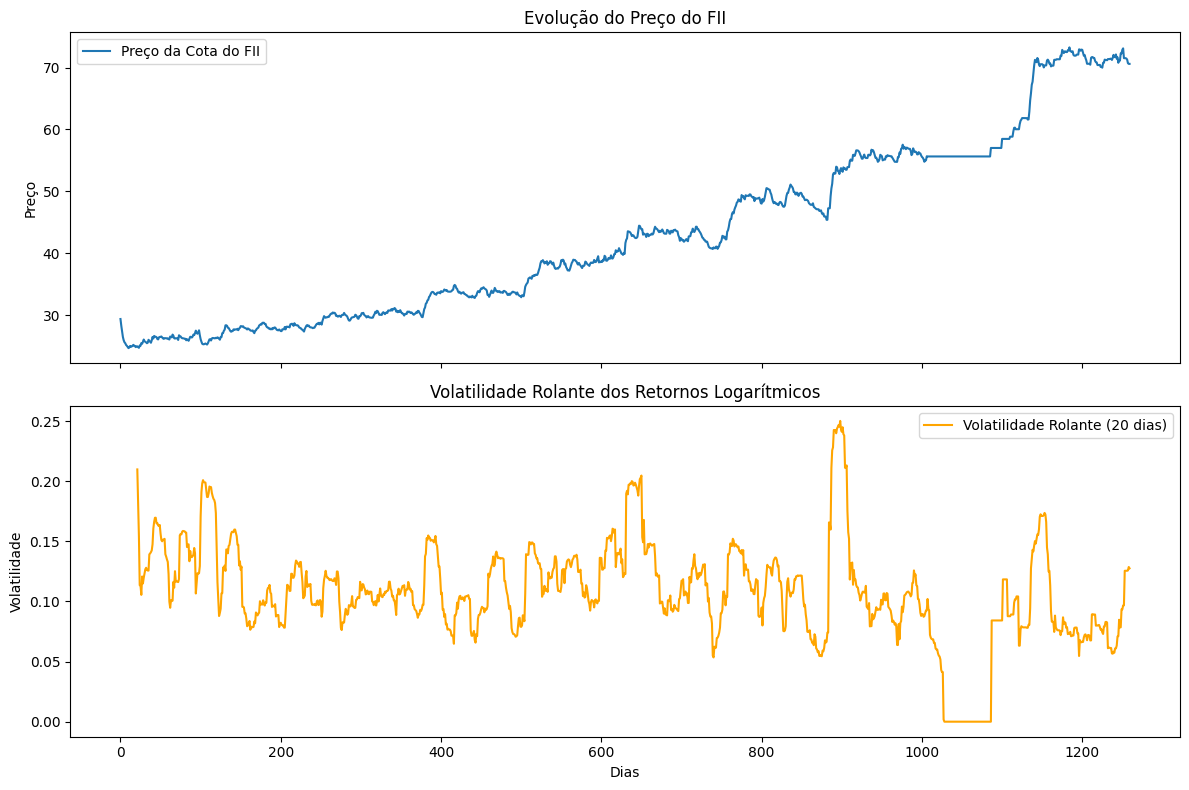

(array([29.38386594, 28.3036202 , 27.39383939, ..., 70.71220241,
        70.59676748, 70.59676748]),
 array([-0.03745603, -0.03267157, -0.03358023, ..., -0.00821382,
        -0.0016338 ,  0.        ]),
 array([       nan,        nan,        nan, ..., 0.1257928 , 0.12863755,
        0.12753703]))

In [ ]:
def simular_mercado_e_plotar():
    # Dicionário unificado de parâmetros
    sim_params = {
        # Parâmetros gerais da simulação
        "num_dias": 1260,
        "total_cota": 100_000,

        # Parâmetros do FII
        "fii": {
            "num_cotas": 100_000,
            "caixa_inicial": 50_000,
            "dividendos_taxa": 0.95,          # Fração do fluxo destinada à distribuição de dividendos
            "dividendos_caixa_taxa": 0.05,      # Fração que permanece no caixa
            "investimento_fracao": 0.50,        # Fração do caixa a ser investida na atualização dos imóveis
        },

        # Parâmetros dos Imóveis (cada dicionário pode ter parâmetros específicos para o imóvel)
        "imoveis": [
            {"valor": 1_000_000, "vacancia": 0.1, "custo_manutencao": 200,
             "params": {"aluguel_factor": 0.005, "desvio_normal": 0.1}},
            {"valor": 2_000_000, "vacancia": 0.2, "custo_manutencao": 500,
             "params": {"aluguel_factor": 0.005, "desvio_normal": 0.1}},
        ],

        # Parâmetros dos Agentes
        "num_agentes": 50,
        "prop_cota_agente": 0.6,
        "agente": {
            "caixa_inicial": 10_000,
            "cotas_iniciais_primeiro": 200,
            "cotas_iniciais_outros": 100,
            "num_vizinhos": 10,
            "literacia_media": 0.4,
            "literacia_std": 0.2,
            "expectativa_inflacao": 0.035,
            "expectativa_premio": 0.08,
            # Parâmetros específicos do Agente (para cálculos internos)
            "params": {
                "window_chart": 21,
                "alpha_chart_short": 0.3,
                "alpha_chart_long": 0.1,
                "ruido_std": 0.1,
                "peso_sentimento": 0.8,
                "peso_riqueza": 0.4,
            }
        },

        # Parâmetros do Banco Central
        "banco_central": {
            "taxa_selic": 0.15,
            "expectativa_inflacao": 0.07,
            "premio_risco": 0.08,
        },

        # Parâmetros da Mídia
        "midia": {
            "noticia_min": -0.5,
            "noticia_max": 0.5,
            "dias_noticia_ruim": [100, 101, 102, 103],
            "valor_noticia_ruim": -3,
        },

        # Parâmetros para o sentimento (utilizados na criação de ordens e nos cálculos dos agentes)
        "parametros_sentimento": {
            "a0": 0,
            "b0": 0.7,
            "c0": 0.3,
            "alpha": 0.3,
            "gamma": 0.1,
            "delta": 0.01,
            "beta": 0.1,
            "peso_preco_esperado": 0.3,
            "quantidade_compra_min": 1,
            "quantidade_compra_max": 10,
            "divisor_quantidade_venda": 5,
        },

        # Parâmetros do Mercado
        "mercado": {
            "volatilidade_inicial": 0.1,
            "dividendos_frequencia": 21,            # Distribuição de dividendos a cada 21 dias
            "atualizacao_imoveis_frequencia": 126,    # Atualização dos imóveis a cada 126 dias
            "dias_noticia_ruim": [100, 101, 102, 103],
            "valor_noticia_ruim": -3,
        },

        # Parâmetros do OrderBook (pode ser extendido futuramente)
        "order_book": {},

        # Parâmetros para Plotagem
        "plot": {
            "window_volatilidade": 20,
        },
    }

    # --- Inicialização do FII e dos Imóveis ---
    total_cota = sim_params["total_cota"]
    num_agentes = sim_params["num_agentes"]
    cota_agente = int(total_cota * sim_params["prop_cota_agente"])
    cota_fii = total_cota - cota_agente

    # Criação do FII com os parâmetros do sim_params["fii"]
    fii = FII(num_cotas=sim_params["fii"]["num_cotas"],
              caixa=sim_params["fii"]["caixa_inicial"],
              params=sim_params["fii"])

    # Adiciona os imóveis ao FII
    for imovel_param in sim_params["imoveis"]:
        imovel = Imovel(valor=imovel_param["valor"],
                        vacancia=imovel_param["vacancia"],
                        custo_manutencao=imovel_param["custo_manutencao"],
                        params=imovel_param.get("params", None))
        fii.adicionar_imovel(imovel)

    # Define o preço inicial da cota e inicializa o histórico
    fii.preco_cota = fii.valor_patrimonial_por_acao()
    print(f"Preço inicial da cota: R${fii.preco_cota:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    historia = fii.inicializar_historico()

    # --- Criação dos Agentes ---
    agentes = []
    for i in range(num_agentes):
        cotas_iniciais = (sim_params["agente"]["cotas_iniciais_primeiro"]
                          if i == 0
                          else sim_params["agente"]["cotas_iniciais_outros"])
        agente = Agente(
            id=i,
            literacia_financeira=np.random.normal(sim_params["agente"]["literacia_media"],
                                                   sim_params["agente"]["literacia_std"]),
            caixa=sim_params["agente"]["caixa_inicial"],
            cotas=cotas_iniciais,
            expectativa_inflacao=sim_params["agente"]["expectativa_inflacao"],
            expectativa_premio=sim_params["agente"]["expectativa_premio"],
            historico_precos=historia,
            params=sim_params["agente"].get("params", None)
        )
        agentes.append(agente)

    # Define os vizinhos para cada agente
    for agente in agentes:
        agente.definir_vizinhos(agentes, num_vizinhos=sim_params["agente"]["num_vizinhos"])

    # --- Criação do Banco Central, Mídia e Mercado ---
    bc = BancoCentral(sim_params["banco_central"])
    midia = Midia(sim_params["midia"])
    mercado = Mercado(agentes=agentes,
                      imoveis=fii.imoveis,
                      fii=fii,
                      banco_central=bc,
                      midia=midia,
                      params=sim_params["mercado"])

    # Parâmetros para o sentimento (passados para os métodos dos agentes)
    parametros_sentimento = sim_params["parametros_sentimento"]

    # --- Loop da Simulação ---
    historico_precos_fii = []
    num_dias = sim_params["num_dias"]
    for dia in range(1, num_dias + 1):
        mercado.executar_dia(parametros_sentimento)
        historico_precos_fii.append(mercado.fii.preco_cota)

    historico_precos_fii = np.array(historico_precos_fii)
    log_returns = np.diff(np.log(historico_precos_fii))

    # --- Cálculo da Volatilidade Rolante ---
    window = sim_params["plot"]["window_volatilidade"]
    volatilidade_rolante = np.full_like(log_returns, np.nan)
    for i in range(window, len(log_returns)):
        volatilidade_rolante[i] = np.std(log_returns[i-window:i]) * (252 ** 0.5)

    # --- Exibição Final---
    print(f"Preço Final da Cota: R${fii.preco_cota:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    print(f"Caixa Final do FII: R${fii.caixa:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))
    for agente in agentes:
      print(f"Agente {agente.id}: Caixa: R${agente.caixa:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")
      + f", Sentimento: {agente.sentimento:.2f}" + f", Riqueza: R${agente.historico_riqueza[-1]:,.2f}"
      .replace(",", "X").replace(".", ",").replace("X", "."))

      #print(f"Agente {agente.id}: Caixa: R${agente.caixa:.2f}, Sentimento: {agente.sentimento:.2f}, Riqueza: R${agente.historico_riqueza[-1]:.2f}")
      ''' a riqueza do agente é calculada como a soma do seu caixa (dinheiro disponível) com o valor de mercado dos ativos que ele possui (por exemplo, o número de cotas de FII multiplicado pelo preço atual da cota).
      Portanto, se um agente investe grande parte do seu caixa em FII e o preço dessas cotas aumenta, ele pode acabar com um caixa baixo, mas uma carteira (ou patrimônio) elevada,
      já que o valor das cotas multiplicado pelo número de ativos supera o valor do caixa.'''

    # --- Plotagem dos Resultados ---
    import matplotlib.pyplot as plt
    dias_array = np.arange(num_dias)
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    ax[0].plot(dias_array, historico_precos_fii, label="Preço da Cota do FII")
    ax[0].set_title("Evolução do Preço do FII")
    ax[0].set_ylabel("Preço")
    ax[0].legend()
    ax[1].plot(dias_array[1:], volatilidade_rolante, label="Volatilidade Rolante (20 dias)", color="orange")
    ax[1].set_title("Volatilidade Rolante dos Retornos Logarítmicos")
    ax[1].set_ylabel("Volatilidade")
    ax[1].set_xlabel("Dias")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

    return historico_precos_fii, log_returns, volatilidade_rolante

# Executa a simulação e plota os resultados
simular_mercado_e_plotar()

In [ ]:
# historico_precos_fii, log_returns, volatilidade_rolante = simular_mercado_e_plotar()

## Distribuição das Notícias

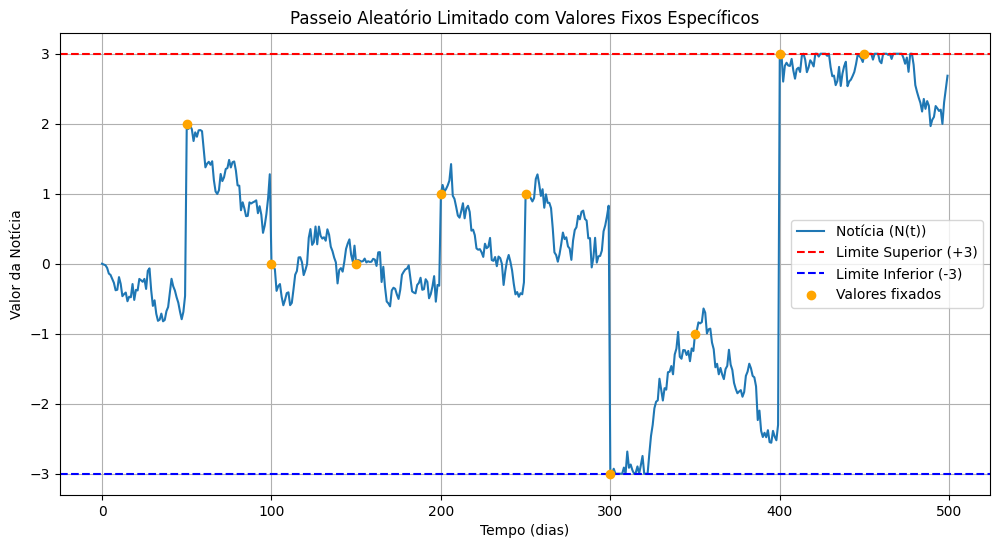

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros da simulação
dias = 500
valor_inicial = 0.0
sigma = 0.15

# Dicionário com dias e valores fixos a serem inseridos
valores_fixos = {
    50: 2,
    100: 0,
    150: 0,
    200: 1,
    250: 1,
    300: -3,
    350: -1,
    400: 3,
    450: 3

}

# Inicialização do passeio aleatório
N = np.zeros(dias)
N[0] = valor_inicial

# Simulação do passeio aleatório limitado com inserções fixas
for t in range(1, dias):
    if t in valores_fixos:
        # Atribui valor fixo conforme especificado no dicionário
        N[t] = valores_fixos[t]
    else:
        # Continua o passeio aleatório limitado
        passo = np.random.normal(0, sigma)
        N[t] = np.clip(N[t-1] + passo, -3, 3)

# Visualização do resultado
plt.figure(figsize=(12, 6))
plt.plot(N, label='Notícia (N(t))')
plt.axhline(3, color='red', linestyle='--', label='Limite Superior (+3)')
plt.axhline(-3, color='blue', linestyle='--', label='Limite Inferior (-3)')

# Destacando pontos fixos
plt.scatter(valores_fixos.keys(), valores_fixos.values(),
            color='orange', zorder=5, label='Valores fixados')

plt.title('Passeio Aleatório Limitado com Valores Fixos Específicos')
plt.xlabel('Tempo (dias)')
plt.ylabel('Valor da Notícia')
plt.legend()
plt.grid(True)
plt.show()
